# Applying Data Science Model Development (MLP_Version2)

## 1. Preprocess the data

In [1]:
# === Step 0: Import Libraries ===
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [2]:
# === Step 1: Data Preparation ===
df = pd.read_csv("Final_v2_processed.csv")
test_df = pd.read_csv("Final_test_v2_processed.csv")

# List of columns to be removed
columns_to_remove = ["recoveries", "last_fico_range_high", "last_fico_range_low", "debt_settlement_flag"]

# Remove the specified column
df = df.drop(columns=columns_to_remove, errors='ignore')  
test_df = test_df.drop(columns=columns_to_remove, errors='ignore')

#Use LabelEncoder to convert the category variable addr_state to a numeric encoding.
le = LabelEncoder()
df["addr_state"] = le.fit_transform(df["addr_state"])
test_df["addr_state"] = le.transform(test_df["addr_state"])

#Specify the target and feature columns
target_col = "loan_status"
feature_cols = [col for col in df.columns if col != target_col and col != "id"]

# Extracting features and labels (to numpy arrays)
X = df[feature_cols].values
y = df[target_col].values
X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

# Standardised feature data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

# Delineate the training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build PyTorch custom dataset classes
class LoanDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Construct training, validation and test sets
train_dataset = LoanDataset(X_train, y_train)
val_dataset = LoanDataset(X_val, y_val)
test_dataset = LoanDataset(X_test, y_test)


## 2. Define MLP Model

In [3]:
# === Step 2: Define MLP Model ===

class MLPClassifier(nn.Module):
    def __init__(self, input_size):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),  # Input to first hidden layer
            nn.ReLU(),
            nn.Linear(64, 32),          # Second hidden layer
            nn.ReLU(),
            nn.Linear(32, 2)            # Output layer (binary classification)
        )

    def forward(self, x):
        return self.model(x)

## 3. Optuna Hyperparameter Tuning (maximize AUC)

In [4]:
def objective(trial):
    # Hyperparameter search space
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # DataLoader configuration
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model and optimizer
    model = MLPClassifier(input_size=X.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train the model (simplified to 10 epochs)
    for epoch in range(10):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluation on validation set — focus on probability output + AUC
    model.eval()
    y_true, y_prob = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            y_true.extend(y_batch.numpy())
            y_prob.extend(probs[:, 1].numpy())  # Probability of predicting "default"

    # Return 1 - AUC (since Optuna minimizes the objective)
    auc = roc_auc_score(y_true, y_prob)
    return 1 - auc

# Run hyperparameter tuning
study = optuna.create_study()
study.optimize(objective, n_trials=20)

# Output best hyperparameters
best_params = study.best_trial.params
print("Best hyperparameters (AUC):", best_params)

[I 2025-04-16 04:36:43,462] A new study created in memory with name: no-name-800d0ccf-af5c-420a-8dea-fa083c63463c
[I 2025-04-16 04:37:30,255] Trial 0 finished with value: 0.3059629920560045 and parameters: {'lr': 0.005163243322948813, 'batch_size': 64}. Best is trial 0 with value: 0.3059629920560045.
[I 2025-04-16 04:38:00,061] Trial 1 finished with value: 0.30438271553354856 and parameters: {'lr': 0.0013373673923756978, 'batch_size': 128}. Best is trial 1 with value: 0.30438271553354856.
[I 2025-04-16 04:38:29,261] Trial 2 finished with value: 0.3063259229880524 and parameters: {'lr': 0.00012166650807843696, 'batch_size': 128}. Best is trial 1 with value: 0.30438271553354856.
[I 2025-04-16 04:39:01,602] Trial 3 finished with value: 0.3024415317357825 and parameters: {'lr': 0.002538338781918238, 'batch_size': 128}. Best is trial 3 with value: 0.3024415317357825.
[I 2025-04-16 04:39:50,898] Trial 4 finished with value: 0.3056608452252332 and parameters: {'lr': 0.005182455063699413, 'bat

Best hyperparameters (AUC): {'lr': 0.0005011699400835125, 'batch_size': 64}


## 4. Re-learn with the optimized parameters

Epoch 1: Train Loss = 0.4230, Val Loss = 0.4164
Epoch 2: Train Loss = 0.4151, Val Loss = 0.4164
Epoch 3: Train Loss = 0.4136, Val Loss = 0.4147
Epoch 4: Train Loss = 0.4122, Val Loss = 0.4143
Epoch 5: Train Loss = 0.4112, Val Loss = 0.4138
Epoch 6: Train Loss = 0.4103, Val Loss = 0.4139
Epoch 7: Train Loss = 0.4091, Val Loss = 0.4167
Epoch 8: Train Loss = 0.4083, Val Loss = 0.4143
Epoch 9: Train Loss = 0.4074, Val Loss = 0.4138
Epoch 10: Train Loss = 0.4064, Val Loss = 0.4143
Early stopping triggered at epoch 10


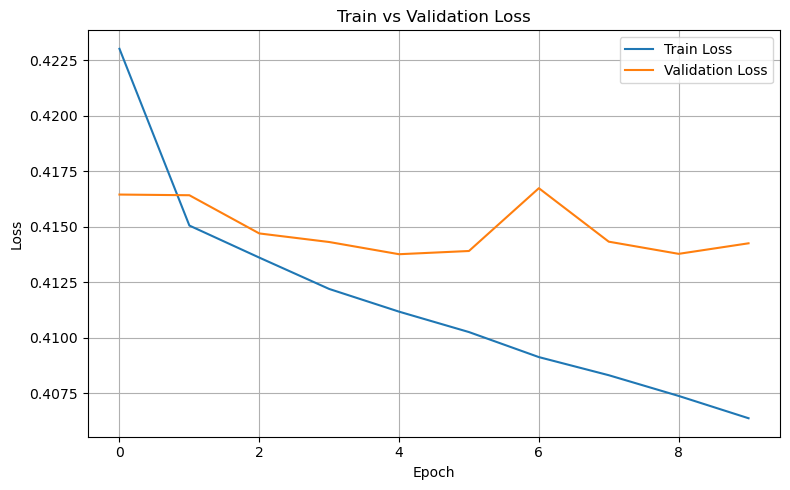

In [5]:
# === Step 4: Train Final Model with Best Parameters ===

# Re-create the data loader (with optimal batch size)
batch_size = best_params['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Re-create the data loader (with optimal batch size)
model = MLPClassifier(input_size=X.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])

# Save the optimal model state with Early Stopping
best_val_loss = float('inf')
epochs_no_improve = 0
patience = 5
n_epochs = 30  

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Preserve optimal model weights
model.load_state_dict(best_model_state)

# Plotting training/validation loss curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Threshold Tuning

Best F1 Threshold (from Validation Set): 0.19, F1 Score: 0.3775
Best G-Mean Threshold (from Validation Set): 0.12, G-Mean: 0.4293


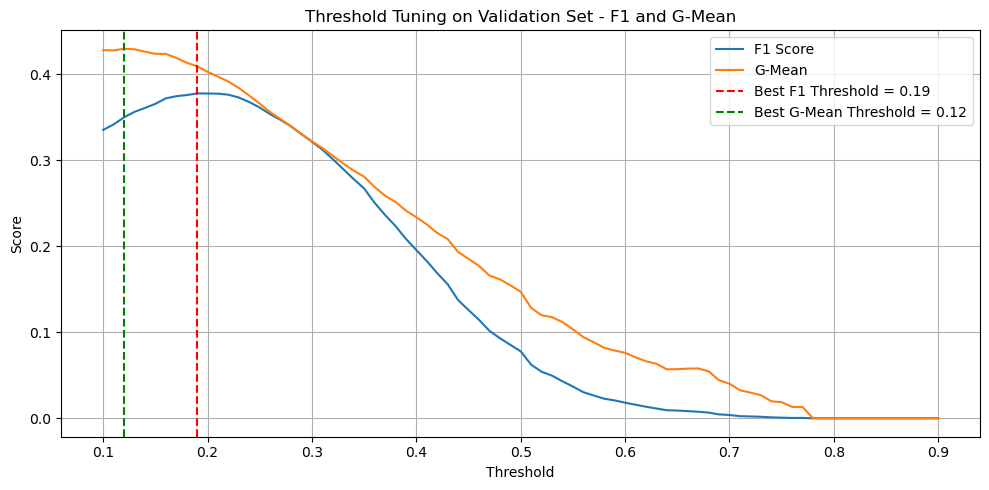

In [6]:
# === Step 5: Threshold Tuning (F1 & G-Mean optimization) on Validation Set ===

# Creating Validation Sets DataLoader
val_loader_eval = DataLoader(val_dataset, batch_size=64)

# Output the predicted probabilities on the validation set using the trained final model
model.eval()
y_true, y_prob = [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader_eval:
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        y_prob.extend(probs[:, 1].numpy())  # Probability of projected ‘default’
        y_true.extend(y_batch.numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)

# Try multiple thresholds, recording F1 and G-Mean for each threshold
thresholds = np.arange(0.1, 0.91, 0.01)
f1_scores = []
gmeans = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    gmean = np.sqrt(precision * recall)

    f1_scores.append(f1)
    gmeans.append(gmean)

# Finding the optimal threshold
best_f1_idx = np.argmax(f1_scores)
best_gmean_idx = np.argmax(gmeans)

best_f1_threshold = thresholds[best_f1_idx]
best_gmean_threshold = thresholds[best_gmean_idx]

print(f"Best F1 Threshold (from Validation Set): {best_f1_threshold:.2f}, F1 Score: {f1_scores[best_f1_idx]:.4f}")
print(f"Best G-Mean Threshold (from Validation Set): {best_gmean_threshold:.2f}, G-Mean: {gmeans[best_gmean_idx]:.4f}")

# Visualisation of F1 and G-Mean curves
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.plot(thresholds, gmeans, label="G-Mean")
plt.axvline(best_f1_threshold, linestyle='--', color='r', label=f'Best F1 Threshold = {best_f1_threshold:.2f}')
plt.axvline(best_gmean_threshold, linestyle='--', color='g', label=f'Best G-Mean Threshold = {best_gmean_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning on Validation Set - F1 and G-Mean")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## 6. Final Evaluation on All Datasets using optimal thresholds


📊 Final Evaluation on Training Set (Threshold = 0.18999999999999995):
Accuracy     : 0.6736
Precision    : 0.2851
Recall       : 0.6419
F1 Score     : 0.3948
Specificity  : 0.6799
AUC          : 0.7230
Confusion Matrix:
[[79063 37231]
 [ 8283 14846]]


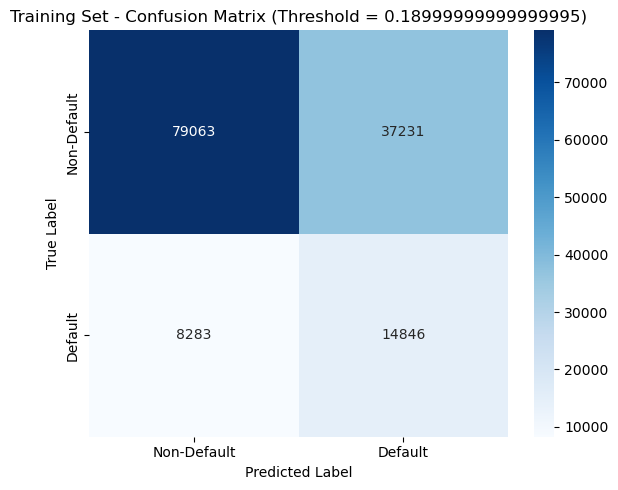


📊 Final Evaluation on Validation Set (Threshold = 0.18999999999999995):
Accuracy     : 0.6644
Precision    : 0.2726
Recall       : 0.6139
F1 Score     : 0.3775
Specificity  : 0.6744
AUC          : 0.6981
Confusion Matrix:
[[19611  9467]
 [ 2231  3547]]


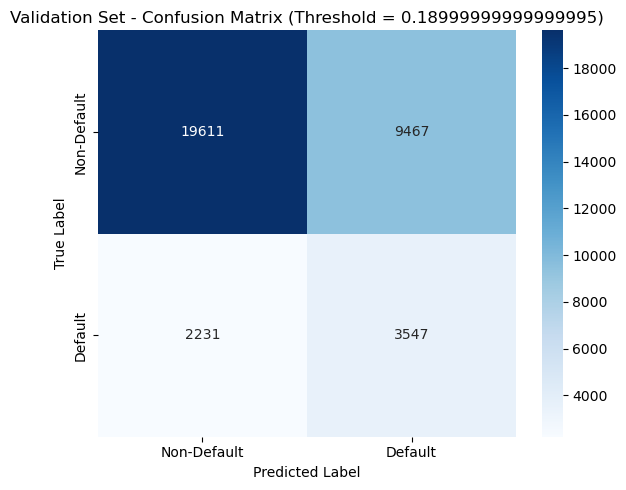


📊 Final Evaluation on Test Set (Threshold = 0.18999999999999995):
Accuracy     : 0.8690
Precision    : 0.2743
Recall       : 0.2386
F1 Score     : 0.2552
Specificity  : 0.9345
AUC          : 0.7329
Confusion Matrix:
[[109575   7686]
 [  9272   2905]]


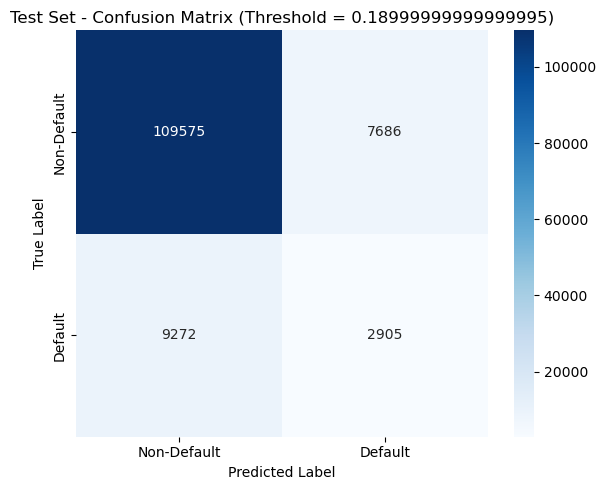


📊 Final Evaluation on Training Set (Threshold = 0.12):
Accuracy     : 0.4932
Precision    : 0.2270
Recall       : 0.8543
F1 Score     : 0.3587
Specificity  : 0.4214
AUC          : 0.7230
Confusion Matrix:
[[49004 67290]
 [ 3369 19760]]


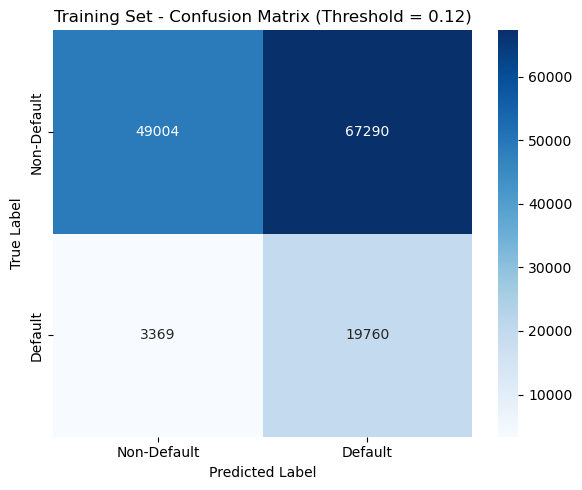


📊 Final Evaluation on Validation Set (Threshold = 0.12):
Accuracy     : 0.4865
Precision    : 0.2213
Recall       : 0.8328
F1 Score     : 0.3497
Specificity  : 0.4177
AUC          : 0.6981
Confusion Matrix:
[[12146 16932]
 [  966  4812]]


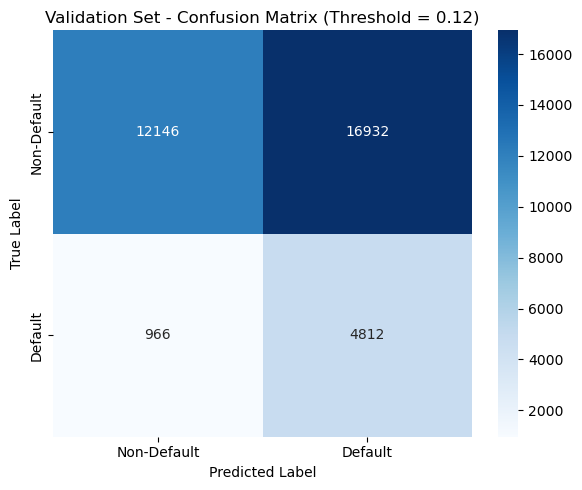


📊 Final Evaluation on Test Set (Threshold = 0.12):
Accuracy     : 0.7866
Precision    : 0.2069
Recall       : 0.4479
F1 Score     : 0.2831
Specificity  : 0.8218
AUC          : 0.7329
Confusion Matrix:
[[96360 20901]
 [ 6723  5454]]


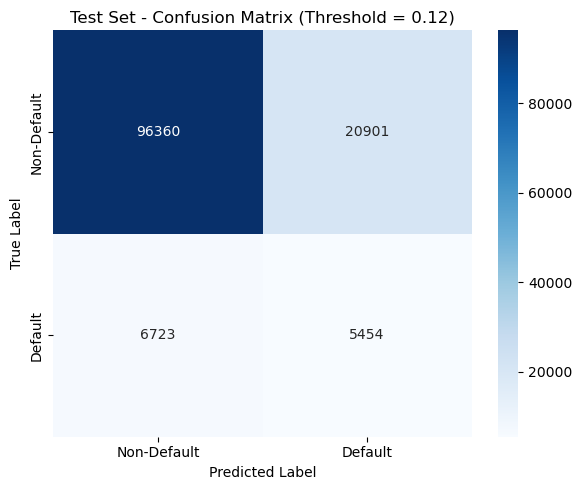

In [7]:
# === Step 6: Final Evaluation on All Datasets using optimal thresholds===

# Unified evaluation function
def evaluate_dataset(dataloader, dataset_name, threshold):
    model.eval()
    y_true, y_prob = [], []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            y_prob.extend(probs[:, 1].numpy())
            y_true.extend(y_batch.numpy())

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = (y_prob >= threshold).astype(int)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Calculation evaluation metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    specificity = tn / (tn + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    auc = roc_auc_score(y_true, y_prob)

    # Print metrics
    print(f"\n📊 Final Evaluation on {dataset_name} (Threshold = {threshold}):")
    print(f"Accuracy     : {accuracy:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"Specificity  : {specificity:.4f}")
    print(f"AUC          : {auc:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{dataset_name} - Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()


# create DataLoader
train_loader_eval = DataLoader(train_dataset, batch_size=64)
val_loader_eval = DataLoader(val_dataset, batch_size=64)
test_loader_eval = DataLoader(test_dataset, batch_size=64)

# Set the final threshold to be used
 # Optional best_f1_threshold or best_gmean_threshold

# Evaluate on all datasets
evaluate_dataset(train_loader_eval, "Training Set", best_f1_threshold)
evaluate_dataset(val_loader_eval, "Validation Set", best_f1_threshold)
evaluate_dataset(test_loader_eval, "Test Set", best_f1_threshold)

evaluate_dataset(train_loader_eval, "Training Set", best_gmean_threshold)
evaluate_dataset(val_loader_eval, "Validation Set", best_gmean_threshold)
evaluate_dataset(test_loader_eval, "Test Set", best_gmean_threshold)


## 7. Optimal Threshold Comparison - F1 vs G-Mean

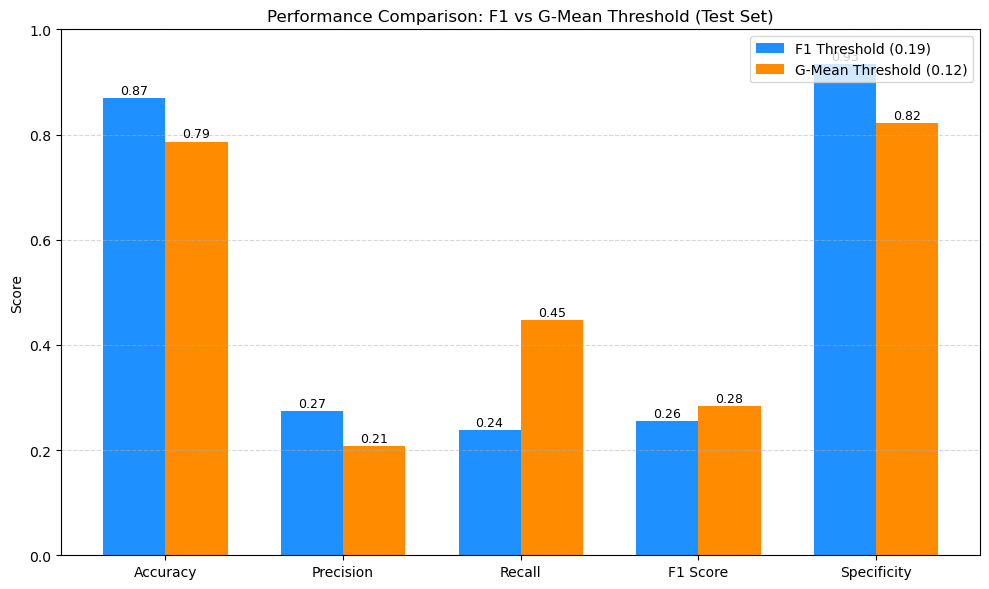

In [10]:
# === Step 7: Optimal Threshold Comparison - F1 vs G-Mean (Bar Chart Style) ===
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 构建比较表格（根据你的测试集预测结果）
# 假设你已经有两个版本的 performance results:
# results = {
#     'F1 Threshold = 0.18': {...},
#     'G-Mean Threshold = 0.10': {...}
# }
# 上一步已经准备好了这个 results 字典

# 将结果转为 DataFrame
df_results = pd.DataFrame(results).T

# 指标名称（固定顺序）
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity']
x = np.arange(len(metrics))  # X轴位置
width = 0.35  # 柱状图宽度

# 图形初始化
fig, ax = plt.subplots(figsize=(10, 6))

# 获取两个模型的指标值
f1_values = [df_results.loc[list(results.keys())[0], metric] for metric in metrics]
gmean_values = [df_results.loc[list(results.keys())[1], metric] for metric in metrics]

# 绘制柱状图
rects1 = ax.bar(x - width/2, f1_values, width, label=list(results.keys())[0], color='dodgerblue')
rects2 = ax.bar(x + width/2, gmean_values, width, label=list(results.keys())[1], color='darkorange')

# 图表设置
ax.set_ylabel('Score')
ax.set_title('Performance Comparison: F1 vs G-Mean Threshold (Test Set)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend(loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.5)

# 添加数值标签
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', fontsize=9)

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()



## While the F1-optimized threshold may look appealing due to its higher accuracy and precision, the G-Mean threshold provides more balanced and risk-aware performance, especially by significantly boosting recall.
## In scenarios where missing a defaulter is more costly than a false alarm (as in credit default prediction), Threshold = 0.12 (G-Mean) is the more practical and robust choice.